This notebook is part of the paper: This notebook is part of the paper: **Combining Deep Learning with Physics Based Features in Explosion-Earthquake Discrimination** published at Geophysical Research Letters.  published at Geophysical Research Letters. 


This notebook contains the code to use GradCAM to visualize what the deep learning branch learned. We only show the visualize of the time series branch, for the spectrogram showing in the paper, it is similar using the following method, so not repeat. 

In [ ]:
import numpy as np
import cv2
import tensorflow as tf

In [2]:
class GradCAM:
    """Code adopted from Pyimagesearch:
    URL https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
    """
    
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
      
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, ps_ratios=None, baseline=False, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            if baseline:
                (convOutputs, predictions) = gradModel([inputs])
            else:
                (convOutputs, predictions) = gradModel([inputs, ps_ratios])
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        #print(cam.numpy())
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        #denom = (heatmap.max() - heatmap.min()) + eps
        denom = (heatmap.max() - heatmap.min())
        heatmap = numer / denom
        #heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap, cam.numpy()
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)
    
mapping = {0:'Exp', 1:"EQ"}

In [3]:
filename = './demo_data.npz'

data = np.load(filename)

# the waveform data
X_waveform = data['X_waveform']
# physics parameters, can be multiple
X_param = data['X_param']
# y label
y = data['y']

X = [X_waveform, X_param]

In [ ]:
# load the trained model
version = '2_1'
output_path = f'./trained_model/Paper_TEST_SSIP/combined_CNN_ANN_model_ver{version}'
model = tf.keras.models.load_model(f'{output_path}/my_best_model.hdf5')
y_pred = model.predict(X)

/tmp/ipykernel_155188/2287247230.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


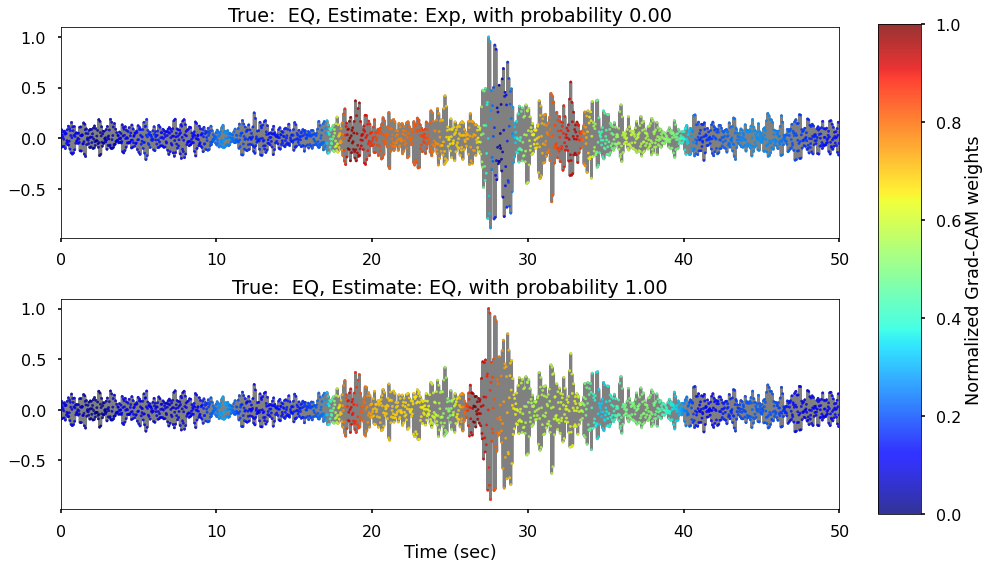

In [5]:
np.random.seed(6)
ix = np.random.choice(range(len(y)), replace=False, size=1)
sampling_rate = 40
times = np.arange(2000)/sampling_rate

cam = GradCAM(model, 0)
heatmap_exp, cam_exp = cam.compute_heatmap(X[0][ix],
                               X[1][ix])

cam = GradCAM(model, 1)
heatmap_eq, cam_eq = cam.compute_heatmap(X[0][ix],
                               X[1][ix])
    
heatmap_exp /= np.max(heatmap_exp)
heatmap_eq /= np.max(heatmap_eq)

tr_data = X[0][ix][0, :, 0, 0]
y_true = y[ix][0]

fig, axes = plt.subplots(nrows=2, figsize=(12, 8))
axes[0].plot(times, tr_data, 'grey')
ymin, ymax = axes[0].get_ylim()
sc=axes[0].scatter(times, tr_data, c=heatmap_exp, cmap=plt.cm.jet, zorder=10, 
           s=5, alpha=0.8)

axes[0].set_title(f'True:  {mapping[y_true]}, Estimate: Exp, with probability {y_pred[ix][0][0]:.2f}')

axes[0].set_xlim(0, 50)
axes[1].plot(times, tr_data, 'grey')
sc=axes[1].scatter(times, tr_data, c=heatmap_eq, cmap=plt.cm.jet, zorder=10, 
           s=5, alpha=0.8)
axes[1].set_title(f'True:  {mapping[y_true]}, Estimate: EQ, with probability {y_pred[ix][0][1]:.2f}')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.1, 0.05, 0.85])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Normalized Grad-CAM weights')

axes[1].set_xlabel('Time (sec)')
plt.tight_layout()
axes[1].set_xlim(0, 50)
plt.show();